In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('B://workspace/tensorflow/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# 训练 Transformer 模型
import numpy as np
from src.trainer.transformer import train_transformer_model

model, test_ = train_transformer_model()

In [39]:
import torch

# 保存模型
torch.save(model, 'model.pth')

In [8]:

# 训练 DF 模型

from src.trainer.rf import train_rf_model

rf_model, test_ = train_rf_model()

200 220
torch.Size([400, 3]) torch.Size([400, 58])
Area: a), Score: 0.917, RMSE: 3.426090931520203, 41.23597117863442 
                origin: max = 26.25819969177246, min = 2.00819993019104 
                predict: max = 26.125560306549072, min = 1.987156800031662
220 240
torch.Size([400, 3]) torch.Size([400, 58])
Area: b), Score: 0.913, RMSE: 0.6837282591414611, 0.05282880289425372 
                origin: max = 28.744600296020508, min = 2.078399896621704 
                predict: max = 28.669997421264647, min = 2.081510985851288
70 90
torch.Size([400, 3]) torch.Size([400, 58])
Area: c), Score: 1.0, RMSE: 0.707549366458909, 0.10081942804124647 
                origin: max = 32.57849884033203, min = 2.69350004196167 
                predict: max = 29.92781607437134, min = 2.7318072595596314
320 340
torch.Size([400, 3]) torch.Size([400, 58])
Area: d), Score: 0.882, RMSE: 0.6328003050910783, 0.22576631729176164 
                origin: max = 27.81679916381836, min = 3.636899948120117 


In [41]:
# 比较预测结果和实际结果

# 预测后 15 天的 SST
import torch
import numpy as np
from loguru import logger
from datetime import datetime
from torch.utils.data import DataLoader

from src.plot.sst import  plot_sst
from src.config.params import Areas
from src.dataset.ERA5 import ERA5SSTDataset
from src.trainer.transformer import get_lon

model = torch.load('model.pth')

offset = 30741 # 2024-03-01

def get_mean_sst(area):
    lon = np.array(get_lon(area['lon']))
    lat = np.array(area['lat']) + 90

    dataset = ERA5SSTDataset(width=15, step=1, offset=offset, lon=lon, lat=lat)

    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    sst_pred = []

    # 滚动预测
    for i in range(15):
        input_, output = next(iter(loader))
        
        # 将输入替换为已经预测的 SST
        if (len(sst_pred) > 0):
            for k in range(len(sst_pred) - 1):
                input_[:, 13 - k, :, :, :] = sst_pred[k]
        else:
            for n in range(14):
                sst_pred.append(input_[:, n, :, :, :])
            sst_pred.append(output)
        
        pred = model(input_)
        
        sst_pred.append(pred)
        
        pred = pred.detach().numpy()[0, 0, :, :]
        output = output.detach().numpy()[0, 0, :, :]
        
        # 计算 RMSE
        rmse = np.sqrt(np.mean((pred - output) ** 2))
        logger.info(f"rmse: {rmse}")
        
        lon = np.array(get_lon(area['lon'])) - 180
        lat = np.array(area['lat'])
        

    # 转化为numpy
    for i in range(len(sst_pred)):
        sst_pred[i] = sst_pred[i].detach().numpy()

    # 计算月平均
    mean_sst = np.nanmean(sst_pred, axis=0)
    
    return mean_sst


C:\Users\Administrator\AppData\Local\Temp\ipykernel_35504\1074773255.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')


In [66]:
# 输入到 RF 模型中

from src.plot.base import create_shared_axes
from src.trainer.rf import get_lat, plot_sst_station, profile_u, get_lon, profile_d
from src.plot.sst import _range
from src.dataset.Argo import Argo3DTemperatureDataset

# 构造数据

def get_profile(area, mean_sst):
    lon = get_lon(np.array(area['lon']))
    lat = get_lat(np.array(area['lat']))

    # 构造输入
    _station = np.array(
                [(i, j) for i in _range(lon) for j in _range(lat - 79) ]
            )

    _sst = mean_sst.reshape(20 * 20, -1).reshape(-1)

    input = np.column_stack([_sst, _station])

    # 预测
    pred = rf_model.predict(input)

    # 获取对比数据
    dataset = Argo3DTemperatureDataset(lon=lon, lat=lat, depth=[0, 58])

    dataset.get_item_at(datetime(2024, 3, 1))

    temp, profile = dataset.__getitem__(241)

    # 对比
    logger.info(f"sst: {temp[0]}, _input: {input[0]}")

    # 转化为 20 * 20 * 58
    profile = profile.reshape(20, 20, 58)
    pred = pred.reshape(20, 20, 58)

    # 上采样
    pred = profile_u(pred)
    profile = profile_u(profile)

    # 计算 每层 SST 的 RMSE
    rmse = np.sqrt(np.mean((pred - profile) ** 2))
    logger.info(f"rmse: {rmse}")

    return pred, profile


2025-01-12 23:12:44.074 | INFO     | __main__:get_mean_sst:53 - rmse: 1.0838899612426758
2025-01-12 23:12:44.121 | INFO     | __main__:get_mean_sst:53 - rmse: 1.030152440071106
2025-01-12 23:12:44.166 | INFO     | __main__:get_mean_sst:53 - rmse: 0.996453046798706


200 220
200 220
200 220
200 220


2025-01-12 23:12:44.213 | INFO     | __main__:get_mean_sst:53 - rmse: 0.9187757968902588
2025-01-12 23:12:44.257 | INFO     | __main__:get_mean_sst:53 - rmse: 1.0432943105697632
2025-01-12 23:12:44.300 | INFO     | __main__:get_mean_sst:53 - rmse: 0.9636663794517517
2025-01-12 23:12:44.345 | INFO     | __main__:get_mean_sst:53 - rmse: 0.8755166530609131
2025-01-12 23:12:44.388 | INFO     | __main__:get_mean_sst:53 - rmse: 1.0034557580947876


200 220
200 220
200 220
200 220
200 220


2025-01-12 23:12:44.432 | INFO     | __main__:get_mean_sst:53 - rmse: 0.8710777759552002
2025-01-12 23:12:44.477 | INFO     | __main__:get_mean_sst:53 - rmse: 0.8837233185768127
2025-01-12 23:12:44.523 | INFO     | __main__:get_mean_sst:53 - rmse: 0.8903716802597046
2025-01-12 23:12:44.574 | INFO     | __main__:get_mean_sst:53 - rmse: 0.8669263124465942
2025-01-12 23:12:44.619 | INFO     | __main__:get_mean_sst:53 - rmse: 0.9840205311775208


200 220
200 220
200 220
200 220


2025-01-12 23:12:44.667 | INFO     | __main__:get_mean_sst:53 - rmse: 0.9298352003097534
2025-01-12 23:12:44.714 | INFO     | __main__:get_mean_sst:53 - rmse: 0.8972536325454712


200 220
200 220
200 220
200 220


2025-01-12 23:12:50.333 | INFO     | __main__:get_profile:34 - sst: [ 24.302 200.     21.   ], _input: [ 19.94355011 200.          21.        ]
2025-01-12 23:12:50.336 | INFO     | __main__:get_profile:46 - rmse: 3.9814740990535253


242
200 220


2025-01-12 23:12:50.761 | INFO     | __main__:get_mean_sst:53 - rmse: 5.464715480804443
2025-01-12 23:12:50.834 | INFO     | __main__:get_mean_sst:53 - rmse: 6.4179863929748535


220 240
220 240
220 240


2025-01-12 23:12:50.907 | INFO     | __main__:get_mean_sst:53 - rmse: 5.975358486175537
2025-01-12 23:12:50.969 | INFO     | __main__:get_mean_sst:53 - rmse: 6.367290019989014
2025-01-12 23:12:51.022 | INFO     | __main__:get_mean_sst:53 - rmse: 6.139884948730469
2025-01-12 23:12:51.074 | INFO     | __main__:get_mean_sst:53 - rmse: 6.157881736755371


220 240
220 240
220 240
220 240


2025-01-12 23:12:51.137 | INFO     | __main__:get_mean_sst:53 - rmse: 6.214311599731445
2025-01-12 23:12:51.187 | INFO     | __main__:get_mean_sst:53 - rmse: 5.696535587310791
2025-01-12 23:12:51.232 | INFO     | __main__:get_mean_sst:53 - rmse: 6.492424964904785
2025-01-12 23:12:51.275 | INFO     | __main__:get_mean_sst:53 - rmse: 6.162031173706055
2025-01-12 23:12:51.322 | INFO     | __main__:get_mean_sst:53 - rmse: 6.292410850524902


220 240
220 240
220 240
220 240


2025-01-12 23:12:51.368 | INFO     | __main__:get_mean_sst:53 - rmse: 6.374894618988037
2025-01-12 23:12:51.414 | INFO     | __main__:get_mean_sst:53 - rmse: 6.4756855964660645
2025-01-12 23:12:51.457 | INFO     | __main__:get_mean_sst:53 - rmse: 6.302407741546631
2025-01-12 23:12:51.501 | INFO     | __main__:get_mean_sst:53 - rmse: 6.113071441650391


220 240
220 240
220 240
220 240
220 240
220 240


2025-01-12 23:12:57.090 | INFO     | __main__:get_profile:34 - sst: [ 20.5492 220.     -34.    ], _input: [ 23.97356415 220.         -34.        ]
2025-01-12 23:12:57.091 | INFO     | __main__:get_profile:46 - rmse: 3.692630472480819


242
220 240


2025-01-12 23:12:57.411 | INFO     | __main__:get_mean_sst:53 - rmse: 4.357100009918213
2025-01-12 23:12:57.474 | INFO     | __main__:get_mean_sst:53 - rmse: 4.288398742675781
2025-01-12 23:12:57.521 | INFO     | __main__:get_mean_sst:53 - rmse: 4.304182529449463


70 90
70 90
70 90
70 90


2025-01-12 23:12:57.567 | INFO     | __main__:get_mean_sst:53 - rmse: 4.248992443084717
2025-01-12 23:12:57.613 | INFO     | __main__:get_mean_sst:53 - rmse: 4.409235000610352
2025-01-12 23:12:57.657 | INFO     | __main__:get_mean_sst:53 - rmse: 4.557455062866211
2025-01-12 23:12:57.703 | INFO     | __main__:get_mean_sst:53 - rmse: 4.103409290313721
2025-01-12 23:12:57.750 | INFO     | __main__:get_mean_sst:53 - rmse: 4.214314937591553


70 90
70 90
70 90
70 90
70 90


2025-01-12 23:12:57.798 | INFO     | __main__:get_mean_sst:53 - rmse: 4.128639221191406
2025-01-12 23:12:57.879 | INFO     | __main__:get_mean_sst:53 - rmse: 4.27146577835083
2025-01-12 23:12:57.943 | INFO     | __main__:get_mean_sst:53 - rmse: 4.424445152282715


70 90
70 90
70 90


2025-01-12 23:12:58.011 | INFO     | __main__:get_mean_sst:53 - rmse: 4.309242248535156
2025-01-12 23:12:58.073 | INFO     | __main__:get_mean_sst:53 - rmse: 4.2833170890808105
2025-01-12 23:12:58.126 | INFO     | __main__:get_mean_sst:53 - rmse: 4.360419750213623
2025-01-12 23:12:58.176 | INFO     | __main__:get_mean_sst:53 - rmse: 4.145908832550049


70 90
70 90
70 90
70 90
70 90


2025-01-12 23:13:03.689 | INFO     | __main__:get_profile:34 - sst: [30.273 70.     1.   ], _input: [25.47908783 70.          1.        ]
2025-01-12 23:13:03.691 | INFO     | __main__:get_profile:46 - rmse: 3.4679241293666183


242
70 90


2025-01-12 23:13:04.082 | INFO     | __main__:get_mean_sst:53 - rmse: 1.6484036445617676
2025-01-12 23:13:04.130 | INFO     | __main__:get_mean_sst:53 - rmse: 1.2764544486999512
2025-01-12 23:13:04.173 | INFO     | __main__:get_mean_sst:53 - rmse: 1.5957170724868774


320 340
320 340
320 340
320 340


2025-01-12 23:13:04.220 | INFO     | __main__:get_mean_sst:53 - rmse: 1.9421724081039429
2025-01-12 23:13:04.265 | INFO     | __main__:get_mean_sst:53 - rmse: 1.4339197874069214
2025-01-12 23:13:04.308 | INFO     | __main__:get_mean_sst:53 - rmse: 1.565042495727539
2025-01-12 23:13:04.353 | INFO     | __main__:get_mean_sst:53 - rmse: 1.462480068206787


320 340
320 340
320 340
320 340


2025-01-12 23:13:04.402 | INFO     | __main__:get_mean_sst:53 - rmse: 1.441916584968567
2025-01-12 23:13:04.446 | INFO     | __main__:get_mean_sst:53 - rmse: 1.8135097026824951
2025-01-12 23:13:04.492 | INFO     | __main__:get_mean_sst:53 - rmse: 1.5884603261947632
2025-01-12 23:13:04.533 | INFO     | __main__:get_mean_sst:53 - rmse: 1.400592565536499
2025-01-12 23:13:04.574 | INFO     | __main__:get_mean_sst:53 - rmse: 1.4801573753356934


320 340
320 340
320 340
320 340
320 340


2025-01-12 23:13:04.617 | INFO     | __main__:get_mean_sst:53 - rmse: 1.434112310409546
2025-01-12 23:13:04.663 | INFO     | __main__:get_mean_sst:53 - rmse: 1.5297096967697144
2025-01-12 23:13:04.706 | INFO     | __main__:get_mean_sst:53 - rmse: 1.5738909244537354


320 340
320 340
320 340
320 340


2025-01-12 23:13:10.583 | INFO     | __main__:get_profile:34 - sst: [ 25.4366 320.      21.    ], _input: [ 19.23135376 320.          21.        ]
2025-01-12 23:13:10.584 | INFO     | __main__:get_profile:46 - rmse: 2.6807735431424624


242
320 340


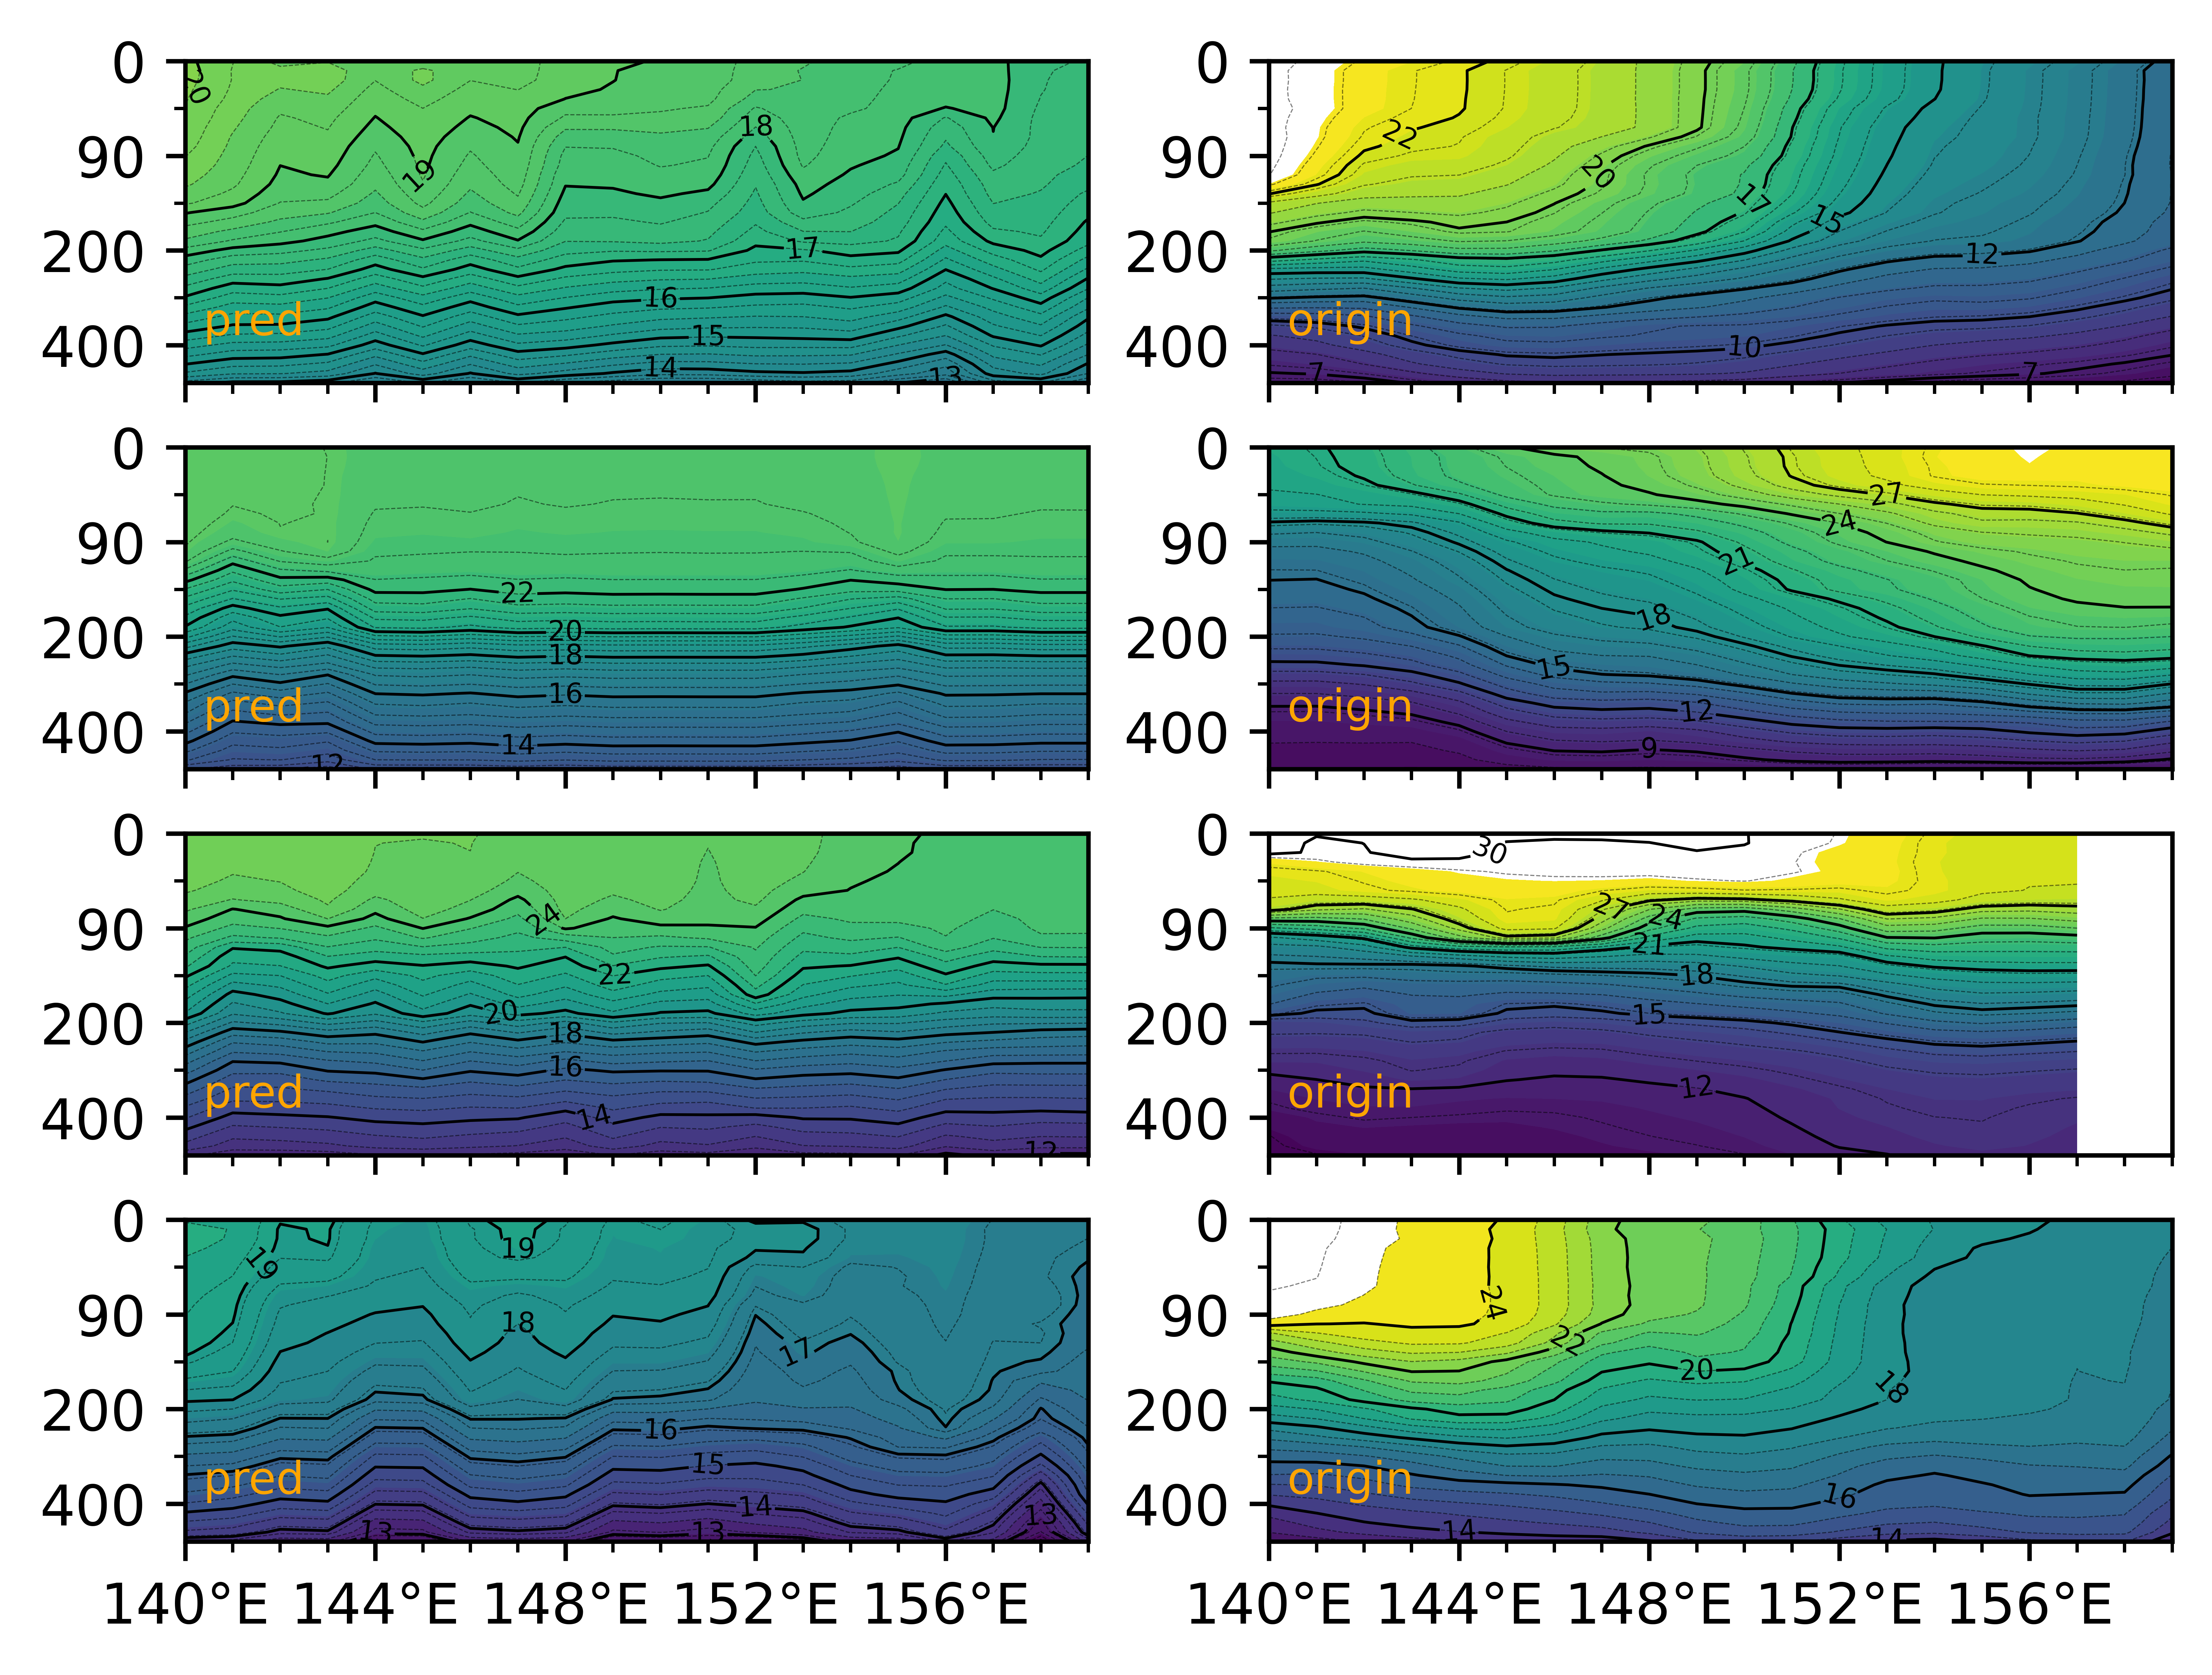

In [67]:

axes = create_shared_axes(4, 2, 'x')

for area, index in zip(Areas, range(len(Areas))):
    mean_sst = get_mean_sst(area)
    pred, profile = get_profile(area, mean_sst)
    
    lon = get_lon(np.array(area['lon']))
    lat = get_lat(np.array(area['lat']))
    
    # 绘制 SST

    ax_1, ax_2 = axes[index]

    vmin = np.around(np.min([np.nanmin(pred), np.nanmin(profile)]), 0)
    vmax = np.around(np.max([np.nanmax(pred), np.nanmax(profile)]), 0)

    levels = np.arange(vmin, vmax, 0.5)

    x_labels = [f"{x:.0f}°E" if x >= 0 else f"{abs(x):.0f}°W" for x in _range(lon - 180, 4)]

    plot_sst_station(pred, ax_1, levels=levels, label='pred', x_labels=x_labels)
    plot_sst_station(profile, ax_2, levels=levels, label='origin', x_labels=x_labels)
